# Convolutional Neural Network Tutorial

Build and implement a convolutional neural network with TensorFlow.

This example is using TensorFlow layers API, see 'convolutional_network_raw' example
for a raw TensorFlow implementation with variables.

- Author: Dr. Deepak Mishra, IIST

## CNN Overview

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
# mnist = tf.keras.datasets.mnist.load_data()
import matplotlib.pyplot as plt
import numpy as np

c:\program files\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Defining Hyperparameters
### Dropout
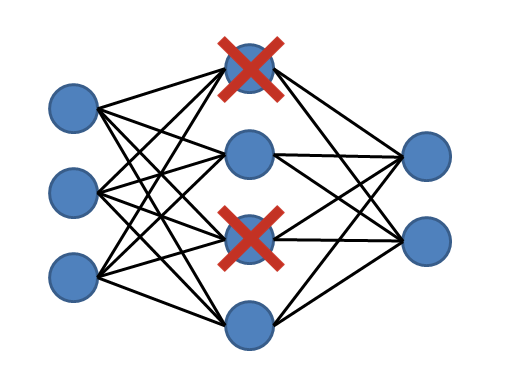
Dropout is regularization technique to avoid overfitting (increase the validation accuracy) thus increasing the generalizing power.

   Generally, use a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.
   
   Use a larger network. You are likely to get better performance when dropout is used on a larger network, giving the model more of an opportunity to learn independent representations.

In [2]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

## Different parts of a CNN
### Convolution


### Pooling
The first secret ingredient that has made CNNs very effective is pooling. Pooling is a vector to scalar transformation that operates on each local region of an image, just like convolutions do, however, unlike convolutions, they do not have filters and do not compute dot products with the local region, instead they compute the average of the pixels in the region (Average Pooling) or simply picks the pixel with the highest intensity and discards the rest (Max Pooling).

Here we use a 2 x 2 pooling, it will effectively reduce the size of feature maps by a factor of 2.



In [3]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

## Model Function

We use ADAM as optimizer because it gives better performance as compared to SGD.

### ADAM:
Adaptive Moment Estimation (Adam) is another method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients vt like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients mt, similar to momentum. Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, which thus prefers flat minima in the error surface. We compute the decaying averages of past and past squared gradients mt and vt respectively as follows:

$$ m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t$$
$$ v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2$$

$m_t$ and $v_t$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively, hence the name of the method. As $m_t$ and $v_t$ are initialized as vectors of 0's, the authors of Adam observe that they are biased towards zero, especially during the initial time steps, and especially when the decay rates are small (i.e. $\beta_1$ and $\beta_2$ are close to 1).

In [4]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [5]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_train_distribute': None, '_model_dir': 'C:\\Users\\samvr\\AppData\\Local\\Temp\\tmpizy0ju_j', '_global_id_in_cluster': 0, '_task_id': 0, '_save_summary_steps': 100, '_master': '', '_tf_random_seed': None, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_session_config': None, '_num_ps_replicas': 0, '_service': None, '_task_type': 'worker', '_is_chief': True, '_evaluation_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002EE006531D0>, '_num_worker_replicas': 1, '_save_checkpoints_steps': None}


In [6]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\samvr\AppData\Local\Temp\tmpizy0ju_j\model.ckpt.
INFO:tensorflow:loss = 2.315802, step = 1
INFO:tensorflow:global_step/sec: 5.63401
INFO:tensorflow:loss = 0.0592588, step = 101 (17.754 sec)
INFO:tensorflow:global_step/sec: 5.53475
INFO:tensorflow:loss = 0.07301702, step = 201 (18.065 sec)
INFO:tensorflow:global_step/sec: 6.18286
INFO:tensorflow:loss = 0.12317712, step = 301 (16.173 sec)
INFO:tensorflow:global_step/sec: 6.14187
INFO:tensorflow:loss = 0.03162294, step = 401 (16.283 sec)
INFO:tensorflow:global_step/sec: 6.17484
INFO:tensorflow:loss = 0.0300324, step = 501 (16.195 sec)
INFO:tensorflow:global_step/sec: 6.14602
INFO:tensorflow:loss = 0.023456499, step = 601 (16.271 sec)
INFO:tensorflow:gl

In [7]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-03-16:32:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\samvr\AppData\Local\Temp\tmpizy0ju_j\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-03-16:32:18
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.988, global_step = 2000, loss = 0.038658466


{'accuracy': 0.988, 'global_step': 2000, 'loss': 0.038658466}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\samvr\AppData\Local\Temp\tmpizy0ju_j\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


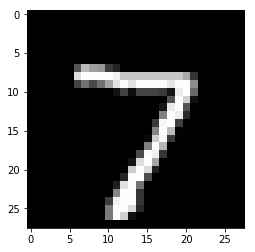

Model prediction: 7


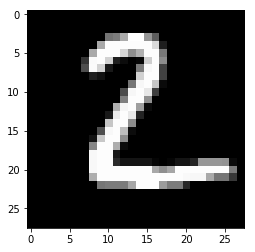

Model prediction: 2


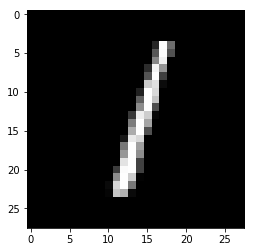

Model prediction: 1


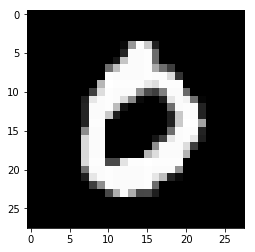

Model prediction: 0


In [8]:
# Predict single images
n_images = 4
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])

## Bibliography

* aymericdamien (GitHub)